In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.STL10(root='data', split='train', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=48, shuffle=True)

# 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data


In [6]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
print('num_ftrs:', num_ftrs)
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

num_ftrs: 512


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [8]:
epochs = 20
model.train()
for epoch in range(epochs):
    
    running_loss = 0.0
    for images, labels in train_loader:
        inputs, labels = images.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss

    cost = running_loss / len(train_loader)
    print(f'[{epoch + 1}] loss: {cost:.3f}')

torch.save(model.state_dict(), 'models/stl10_resnet18.pth')

print('Finished Training.')

[1] loss: 0.548
[2] loss: 0.096
[3] loss: 0.045
[4] loss: 0.034
[5] loss: 0.047
[6] loss: 0.119
[7] loss: 0.124
[8] loss: 0.054
[9] loss: 0.070
[10] loss: 0.037
[11] loss: 0.042
[12] loss: 0.108
[13] loss: 0.066
[14] loss: 0.080
[15] loss: 0.038
[16] loss: 0.045
[17] loss: 0.103
[18] loss: 0.117
[19] loss: 0.063
[20] loss: 0.073
Finished Training.


In [16]:
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
model.load_state_dict(torch.load('models/stl10_resnet18.pth'))

<All keys matched successfully>

In [17]:
correct = 0
total = 0
model.eval()
with torch.inference_mode():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total += len(labels)
        correct += (outputs.argmax(axis=1) == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct / total:.2f}%')

Accuracy of the network on the train images: 99.62%


In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [48]:
def cam(model, trainset, img_sample_idx, img_size):
    model.eval()
    with torch.inference_mode():
        model.layer4[1].bn2.register_forward_hook(get_activation('final'))
        data, _ = trainset[img_sample_idx]
        data = data.unsqueeze(0)
        output = model(data.to(device))
        pred = output.argmax(axis=1)
        act = activation['final'].squeeze()
        w = model.fc.weight

        for idx in range(act.size(0)):
            if idx == 0:
                tmp = act[idx] * w[pred.item()][idx]
            else:
                tmp += act[idx] * w[pred.item()][idx]

        cam = tmp.cpu().numpy()
        normalized_cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size))

    return cam_img, original_img

In [49]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    axs = axs.ravel()
    for i in range(start, end):
        cam_img, original_img = cam(model, trainset, i, img_size)
        axs[i-start].imshow(original_img, cmap='gray')
        axs[i-start].imshow(cam_img, cmap='jet', alpha=0.5)
        axs[i-start].axis('off')

    plt.show()
    fig.savefig('cam.png')

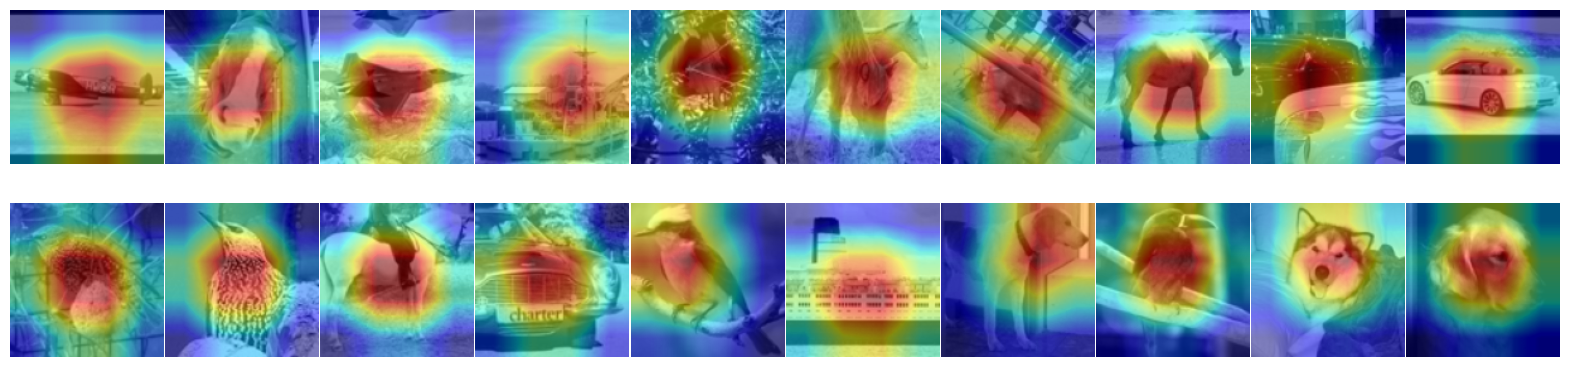

In [50]:
plot_cam(model, trainset, 128, 10)